## Predicting Home Loans

Source: https://www.kaggle.com/ufffnick/loan-prediction-dream-housing-finance   
Data: https://www.kaggle.com/burak3ergun/loan-data-set

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes
import pickle

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc

### import data

In [3]:
loans_df = pd.read_csv('../data/loan_data_set.csv')
loans_df.shape

(614, 13)

## Exploratory Data Analysis

In [4]:
# target variable: Approval of Mortgage Loan
print(loans_df[['Loan_Status']].value_counts())

Loan_Status
Y              422
N              192
dtype: int64


In [5]:
# continuous variables
print('\n',loans_df[['ApplicantIncome']].agg(['mean','median','min','max', 'std']))
print('\n',loans_df[['CoapplicantIncome']].agg(['mean','median','min','max', 'std']))
print('\n',loans_df[['LoanAmount']].agg(['mean','median','min','max', 'std']))


         ApplicantIncome
mean        5403.459283
median      3812.500000
min          150.000000
max        81000.000000
std         6109.041673

         CoapplicantIncome
mean          1621.245798
median        1188.500000
min              0.000000
max          41667.000000
std           2926.248369

         LoanAmount
mean    146.412162
median  128.000000
min       9.000000
max     700.000000
std      85.587325


In [6]:
# categorical variables
print('\n',loans_df[['Loan_Amount_Term']].value_counts().head())
print('\n',loans_df[['Property_Area']].value_counts())
print('\n',loans_df[['Gender']].value_counts())
print('\n',loans_df[['Education']].value_counts())
print('\n',loans_df[['Self_Employed']].value_counts())
print('\n', loans_df[['Credit_History']].value_counts())


 Loan_Amount_Term
360.0               512
180.0                44
480.0                15
300.0                13
84.0                  4
dtype: int64

 Property_Area
Semiurban        233
Urban            202
Rural            179
dtype: int64

 Gender
Male      489
Female    112
dtype: int64

 Education   
Graduate        480
Not Graduate    134
dtype: int64

 Self_Employed
No               500
Yes               82
dtype: int64

 Credit_History
1.0               475
0.0                89
dtype: int64


In [7]:
loans_df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [8]:
loan = loans_df

In [9]:
loan.Loan_Status.value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [10]:
loan.drop(['Loan_ID'], axis=1, inplace=True)

In [11]:
loan.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [231]:
loan['Education'].replace(['Graduate', 'Not Graduate'],
                        [1, 0], inplace=True)

In [12]:
loan['Loan_Status'].replace(['Y', 'N'],
                        [1, 0], inplace=True)

In [13]:
loan.Loan_Status.value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

### Data Cleaning
- drop all NAs
- in a future iteration, we might improve performance by imputing rather than dropping

In [14]:
# check for missing data
loan.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [15]:
loan=loan.dropna()

In [16]:
loan.Loan_Status.value_counts()

1    332
0    148
Name: Loan_Status, dtype: int64

In [251]:
# remove missing data & reset the index
#loans_df.dropna(inplace=True)
loan.reset_index(drop=True, inplace=True)

## Categorical variables
- each column translated to binary value
- multi variables columns slpitted with dummy columns
- drop the duplications in the data

### Adding new features:
- one hot encoding
- naive estimation of monthly loan return (LoanAmount/Loan_Amount_Term) 
- total income (ApplicantIncome + CoaplicantIncome) 
- both standardized and with ln() to get the distribution as close as possible to a normal distribution

In [17]:
dummies=pd.get_dummies(loan, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

In [253]:
loan.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
1,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
2,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
3,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1
4,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,1


In [254]:
loan.Loan_Status.value_counts()

1    332
0    148
Name: Loan_Status, dtype: int64

In [255]:
loan.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [256]:
loan.shape

(480, 12)

In [257]:
dummies.shape

(480, 21)

In [280]:
dummies.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Gender_Female',
       'Gender_Male', 'Married_No', 'Married_Yes', 'Dependents_0',
       'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Education_Graduate',
       'Education_Not Graduate', 'Self_Employed_No', 'Self_Employed_Yes',
       'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban'],
      dtype='object')

In [259]:
dummies.Loan_Status.value_counts()

1    332
0    148
Name: Loan_Status, dtype: int64

In [261]:
dummies.head(5)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,4583,1508.0,128.0,360.0,1.0,0,0,1,0,1,...,1,0,0,1,0,1,0,1,0,0
1,3000,0.0,66.0,360.0,1.0,1,0,1,0,1,...,0,0,0,1,0,0,1,0,0,1
2,2583,2358.0,120.0,360.0,1.0,1,0,1,0,1,...,0,0,0,0,1,1,0,0,0,1
3,6000,0.0,141.0,360.0,1.0,1,0,1,1,0,...,0,0,0,1,0,1,0,0,0,1
4,5417,4196.0,267.0,360.0,1.0,1,0,1,0,1,...,0,1,0,1,0,0,1,0,0,1


In [18]:
loan = dummies

In [19]:
loan.head(5)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
1,4583,1508.0,128.0,360.0,1.0,0,0,1,0,1,...,1,0,0,1,0,1,0,1,0,0
2,3000,0.0,66.0,360.0,1.0,1,0,1,0,1,...,0,0,0,1,0,0,1,0,0,1
3,2583,2358.0,120.0,360.0,1.0,1,0,1,0,1,...,0,0,0,0,1,1,0,0,0,1
4,6000,0.0,141.0,360.0,1.0,1,0,1,1,0,...,0,0,0,1,0,1,0,0,0,1
5,5417,4196.0,267.0,360.0,1.0,1,0,1,0,1,...,0,1,0,1,0,0,1,0,0,1


In [20]:
loan.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Gender_Female',
       'Gender_Male', 'Married_No', 'Married_Yes', 'Dependents_0',
       'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Education_Graduate',
       'Education_Not Graduate', 'Self_Employed_No', 'Self_Employed_Yes',
       'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban'],
      dtype='object')

In [21]:
loan.Loan_Status.value_counts()

1    332
0    148
Name: Loan_Status, dtype: int64

In [22]:
loan = loan.astype({"Loan_Status":"int"})

In [23]:
loan.Loan_Status.value_counts()

1    332
0    148
Name: Loan_Status, dtype: int64

## Class Imbalance

In [24]:
count_class_0, count_class_1 = loan.Loan_Status.value_counts()
# Divide by class
df_class_0 = loan[loan['Loan_Status'] == 0]
df_class_1 = loan[loan['Loan_Status'] == 1]

In [25]:
print('Random over-sampling:')
loan_0_over = df_class_0.sample(count_class_0,random_state=21, replace=True)
loan_0_over = pd.concat([df_class_1, loan_0_over], axis=0)

Random over-sampling:


In [26]:
loan_0_over.Loan_Status.value_counts()

1    332
0    332
Name: Loan_Status, dtype: int64

In [27]:
loan=loan_0_over

In [28]:
loan.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Gender_Female',
       'Gender_Male', 'Married_No', 'Married_Yes', 'Dependents_0',
       'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Education_Graduate',
       'Education_Not Graduate', 'Self_Employed_No', 'Self_Employed_Yes',
       'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban'],
      dtype='object')

In [29]:
loan.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

## Feature selection

In [30]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import pickle

In [31]:
# Splitting the dataset into the Training set and Test set
X = loan.drop('Loan_Status', axis = 1)
y = loan.Loan_Status


from sklearn.model_selection import train_test_split

training_features, test_features, \
training_target, test_target, = train_test_split(X,y,
                                               test_size = .3,
                                               random_state= 21)

[0.0422744  0.0575908  0.0464057  0.0537682  0.34101593 0.052864
 0.         0.07543401 0.         0.01864308 0.05343517 0.03235725
 0.01680426 0.04536111 0.         0.02580076 0.         0.07456017
 0.04739195 0.01629313]


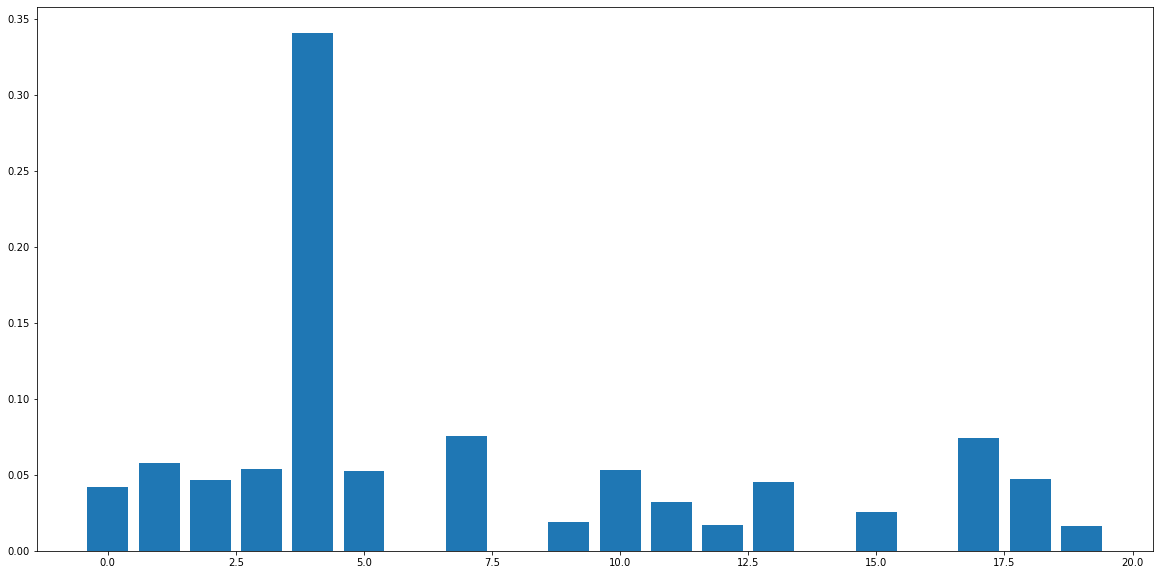

In [32]:
from xgboost import XGBClassifier
from matplotlib import pyplot

plt.figure(figsize=(20,10))

# fit model no training data
model = XGBClassifier()
model.fit(training_features, training_target)
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [33]:
feature_importances = pd.DataFrame({'Importance Coef' :model.feature_importances_ , 'Features' : training_features.columns})
feature_importances.nlargest(19, 'Importance Coef')

,Importance Coef,Features
4,0.341016,Credit_History
7,0.075434,Married_No
17,0.074560,Property_Area_Rural
1,0.057591,CoapplicantIncome
3,0.053768,Loan_Amount_Term
10,0.053435,Dependents_1
5,0.052864,Gender_Female
18,0.047392,Property_Area_Semiurban
2,0.046406,LoanAmount
13,0.045361,Education_Graduate


In [34]:
loan=loan.drop(['Education_Not Graduate', 'Married_Yes','Gender_Male'], axis='columns')

## Scaling the Features

In [35]:
# train-test split
X=loan.drop(columns=['Loan_Status'])
y=loan['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                     test_size=.3,
                                                     stratify=loan['Loan_Status'])

In [36]:
import sklearn
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

In [38]:
# 'Fit' the scaler to our X_train data
std_scaler = std_scaler.fit(X_train.values)
std_scaler

StandardScaler()

In [39]:
X_train_scaled = std_scaler.transform(X_train.values)
X_train_scaled[0]

array([-0.25520788,  0.85714233,  0.82899791,  0.25860525,  0.55411394,
       -0.46674165, -0.73588602,  0.88578518, -0.46331381, -0.43909231,
       -0.33572285,  0.5006734 ,  0.40722125, -0.40722125, -0.71168357,
        1.34615052, -0.66744503])

In [40]:
# Use the scaler to transform the dataset
X_test_scaled = std_scaler.transform(X_test.values)
X_test_scaled[0]

array([-0.27965023, -0.72125213, -0.48775597,  0.25860525,  0.55411394,
       -0.46674165,  1.35890609,  0.88578518, -0.46331381, -0.43909231,
       -0.33572285, -1.99731002,  0.40722125, -0.40722125,  1.40511885,
       -0.74285898, -0.66744503])

In [41]:
X_train=X_train_scaled
X_test=X_test_scaled

In [129]:
training_features.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Gender_Female', 'Gender_Male',
       'Married_No', 'Married_Yes', 'Dependents_0', 'Dependents_1',
       'Dependents_2', 'Dependents_3+', 'Education_Graduate',
       'Education_Not Graduate', 'Self_Employed_No', 'Self_Employed_Yes',
       'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban'],
      dtype='object')

## Model evaluation 

In [42]:
def mod_eval(df,predictions, y_test, title):
    # prints confusion matrix heatmap    
    cm = confusion_matrix(df['Loan_Status'][y_test.index], predictions)
    sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes']).set_title(title)
    plt.xlabel('Real')
    plt.ylabel('Predict')
    
    print(classification_report(df['Loan_Status'][y_test.index], predictions))

## RandomForest

In [43]:
# grid search for optimal hyperparameters
grid_values = {'max_features': [4, 5, 6, 7],
              'max_depth': [3, 7, 11, 13],
               'n_estimators':[50,100,150]
              }

In [44]:
# grid search for optimal hyperparameters
model = RandomForestClassifier(random_state=42, 
                               n_jobs=4)
rf = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
rf.fit(X_train,y_train)
print(rf.best_params_)
print(rf.best_score_)

{'max_depth': 13, 'max_features': 4, 'n_estimators': 50}
0.8771388499298738


              precision    recall  f1-score   support

           0       0.87      0.86      0.86       100
           1       0.86      0.87      0.87       100

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200



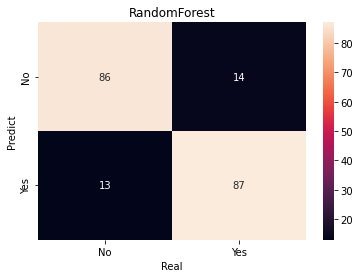

In [45]:
# evaluate the model
predprob = rf.predict_proba(X_test)
mod_eval(loans_df, rf.predict(X_test),  y_test, 'RandomForest')

In [46]:
print(predprob)

[[0.12564413 0.87435587]
 [0.96       0.04      ]
 [0.98       0.02      ]
 [0.30771717 0.69228283]
 [0.94       0.06      ]
 [1.         0.        ]
 [0.02505925 0.97494075]
 [0.32       0.68      ]
 [0.135      0.865     ]
 [0.16599379 0.83400621]
 [0.16153918 0.83846082]
 [0.08       0.92      ]
 [0.96       0.04      ]
 [0.23083405 0.76916595]
 [0.78       0.22      ]
 [0.97666667 0.02333333]
 [0.89882433 0.10117567]
 [0.07230958 0.92769042]
 [0.15230958 0.84769042]
 [0.10064252 0.89935748]
 [0.54327273 0.45672727]
 [0.88       0.12      ]
 [0.18215618 0.81784382]
 [0.18       0.82      ]
 [0.72510378 0.27489622]
 [0.80166667 0.19833333]
 [0.94       0.06      ]
 [0.12       0.88      ]
 [0.59661202 0.40338798]
 [0.24       0.76      ]
 [1.         0.        ]
 [0.845      0.155     ]
 [0.17       0.83      ]
 [0.97707071 0.02292929]
 [1.         0.        ]
 [0.68988235 0.31011765]
 [0.04505925 0.95494075]
 [0.72208152 0.27791848]
 [0.98       0.02      ]
 [1.         0.        ]


In [47]:
print(predprob[0][1])

0.8743558696205755


In [48]:
print(predprob[0][0])

0.12564413037942448


In [49]:
#print(X_test)

In [50]:
print(rf.predict(X_test))

[1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 1
 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1
 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0
 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0
 0 0 0 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1
 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1]


## LogisticRegression

In [51]:
# grid search for optimal hyperparameters
grid_values = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
               'solver':['liblinear'] # this is the only solver that allow parameters
              }

In [52]:
# grid search for optimal hyperparameters
model = LogisticRegression(max_iter=1000)
lr = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
lr.fit(X_train,y_train)
print(lr.best_params_)
print(lr.best_score_)

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.7090930341280972


              precision    recall  f1-score   support

           0       0.82      0.54      0.65       100
           1       0.66      0.88      0.75       100

    accuracy                           0.71       200
   macro avg       0.74      0.71      0.70       200
weighted avg       0.74      0.71      0.70       200



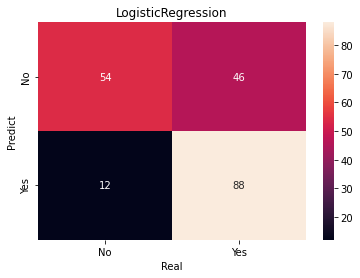

In [53]:
# evaluate the model
predprob = lr.predict_proba(X_test)
mod_eval(loans_df, lr.predict(X_test), y_test, 'LogisticRegression') 

## NaiveBayes

              precision    recall  f1-score   support

           0       0.86      0.60      0.71       100
           1       0.69      0.90      0.78       100

    accuracy                           0.75       200
   macro avg       0.77      0.75      0.74       200
weighted avg       0.77      0.75      0.74       200



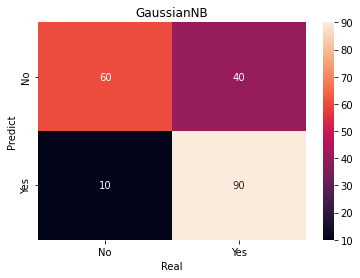

In [54]:
# there are no hyperparameters to gridsearch
gnb = GaussianNB()
gnb.fit(X_train, y_train)
mod_eval(loans_df, gnb.predict(X_test),  y_test, 'GaussianNB')

## SVC

In [55]:
# grid search for optimal hyperparameters
grid_values = {'C': [1, 10],
              'gamma': [0.5, 0.7, 0.9, 0.95],
              'kernel':['linear','poly','rbf']
              }

In [56]:
# grid search for optimal hyperparameters
model = SVC(class_weight='balanced',probability=True)
svc = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
svc.fit(X_train,y_train)
print(svc.best_params_)
print(svc.best_score_)

{'C': 10, 'gamma': 0.7, 'kernel': 'rbf'}
0.8017531556802243


              precision    recall  f1-score   support

           0       0.86      0.81      0.84       100
           1       0.82      0.87      0.84       100

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200



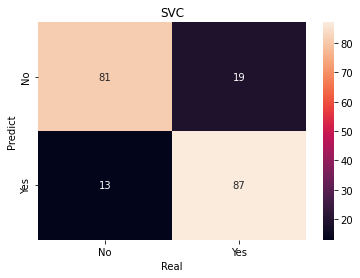

In [57]:
# evaluate
predprob = svc.predict_proba(X_test)
mod_eval(loans_df,svc.predict(X_test), y_test, 'SVC')
plt.show()

## Adaboost

In [58]:
# grid search for optimal hyperparameters
grid_values = {'learning_rate': [1, 2, 3],
               'n_estimators':[50,100,150]}

In [59]:
# grid search for optimal hyperparameters
model = AdaBoostClassifier()
boost = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
boost.fit(X_train,y_train)
print(boost.best_params_)
print(boost.best_score_)

{'learning_rate': 1, 'n_estimators': 100}
0.7888499298737728


              precision    recall  f1-score   support

           0       0.83      0.83      0.83       100
           1       0.83      0.83      0.83       100

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.83      0.83      0.83       200



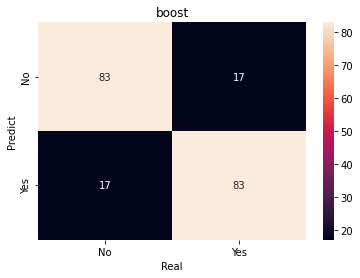

In [60]:
# evaluate the model
predprob = boost.predict_proba(X_test)
mod_eval(loans_df,boost.predict(X_test),  y_test, 'boost')
plt.show()

## XG Boost

In [102]:
# grid search for optimal hyperparameters
grid_values = {'learning_rate': [1, 2, 3],
               'n_estimators':[50,100,150]}

In [115]:
# grid search for optimal hyperparameters
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1,monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
xgboost = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
xgboost.fit(X_train,y_train)
print(xgboost.best_params_)
print(xgboost.best_score_)

{'learning_rate': 1, 'n_estimators': 150}
0.8232351566152406


              precision    recall  f1-score   support

           0       0.84      0.85      0.85       100
           1       0.85      0.84      0.84       100

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.84      0.84       200



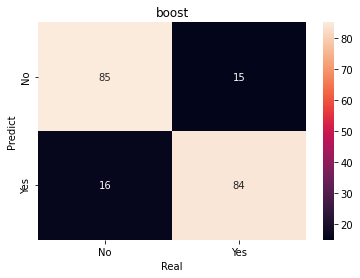

In [116]:
# evaluate the model
predprob = xgboost.predict_proba(X_test)
mod_eval(loans_df,xgboost.predict(X_test),  y_test, 'boost')
plt.show()

## Compare Models

In [118]:
# compare final models: accuracy
import sklearn
accuracy_vals=[]
for val in [rf.predict(X_test),
lr.predict(X_test),
gnb.predict(X_test),
svc.predict(X_test),
boost.predict(X_test),      
xgboost.predict(X_test),
           ]:
    accuracy_vals.append(sklearn.metrics.accuracy_score(val, y_test.values))
accuracy_vals

[0.865, 0.71, 0.75, 0.84, 0.83, 0.845]

In [119]:
# compare final models: ROCAUC
roc_vals=[]
for val in [rf.predict(X_test),
            lr.predict(X_test),
            gnb.predict(X_test),
            svc.predict(X_test),
           boost.predict(X_test),
           xgboost.predict(X_test)]:
    roc_vals.append(sklearn.metrics.roc_auc_score(val, y_test.values))
roc_vals

[0.865036503650365,
 0.7374491180461329,
 0.7747252747252749,
 0.8412284223203533,
 0.83,
 0.8450345034503451]

In [120]:
# display final values
models = ['random forest', 'logistic regression', 'naive bayes', 'support vector', 'adaboosted','xgboost']
evaldf = pd.DataFrame(list(zip(models, accuracy_vals, roc_vals)))
evaldf.columns=['model', 'accuracy', 'rocauc']
evaldf=evaldf.set_index('model', drop=True)
evaldf

,accuracy,rocauc
model,,
random forest,0.865,0.865037
logistic regression,0.710,0.737449
naive bayes,0.750,0.774725
support vector,0.840,0.841228
adaboosted,0.830,0.830000
xgboost,0.845,0.845035


In [121]:
import plotly.graph_objs as go

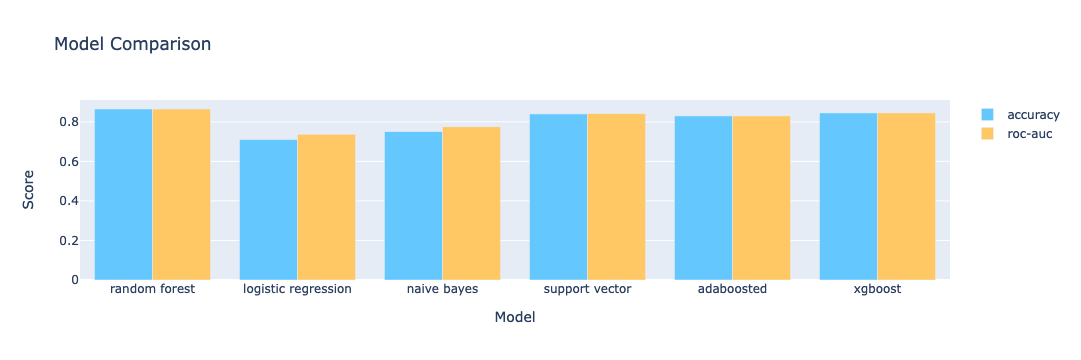

In [122]:
# display results with plotly
trace0 = go.Bar(x= evaldf.index,
                y= evaldf['accuracy'].values,
                name='accuracy',
                marker=dict(color='rgb(100,200,300)'))
trace1 = go.Bar(x= evaldf.index,
                y= evaldf['rocauc'].values,
                name='roc-auc',
                marker=dict(color='rgb(300,200,100)'))
# now the layout
layout=go.Layout(title='Model Comparison',
                   xaxis= dict(title='Model'),
                   yaxis=dict(title='Score'))
# bind using go.Figure
fig = go.Figure(data=[trace0, trace1], layout=layout)
fig

### Side note: Visualize the ROC-AUC curve

In [123]:
# true positives, etc.
y_score = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresh=roc_curve(y_test, y_score)
roc_df=pd.DataFrame(zip(fpr, tpr, thresh), columns=['FPR','TPR','Threshold'])
roc_df.head()


,FPR,TPR,Threshold
0,0.00,0.00,2.000000
1,0.00,0.01,1.000000
2,0.00,0.05,0.980774
3,0.03,0.07,0.980000
4,0.03,0.08,0.974941


In [124]:
import plotly.express as px

def make_rocauc(i):
    nearest=roc_df.iloc[(roc_df['Threshold']-i).abs().argsort()[:1]]['Threshold'].values[0]
    q=roc_df[roc_df['Threshold']==nearest].index[0]
    print(nearest, q)
    fig = px.area(roc_df, x="FPR", y="TPR",
                  title=f'ROC Curve (AUC={auc(fpr, tpr):.3f})',
                  hover_data={'Threshold':':.2f',
                              'FPR':':.2f',
                              'TPR':':.2f',
                             },width=800, height=700)

    fig.add_annotation(x=roc_df.iloc[q][0], y=roc_df.iloc[q][1],
            text=f"Threshold nearest {i*100:.0f}% = {roc_df.iloc[q][2]:.2f}",
                showarrow=True,
                arrowhead=1)

    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    return fig

0.6056 20


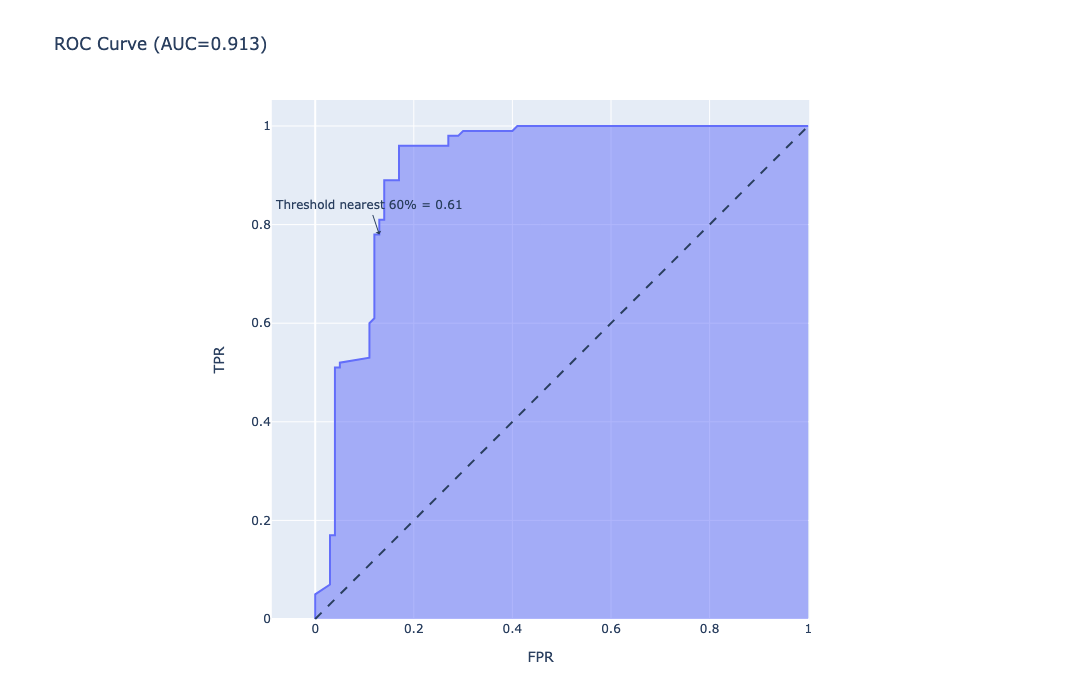

In [125]:
# choose a threshold for prediction.
make_rocauc(.60)

## Take a look at the final results

In [134]:
# grid search for optimal hyperparameters
grid_values = {'max_features': [4, 5, 6, 7],
              'max_depth': [3, 7, 11, 13],
               'n_estimators':[50,100,150]
              }

In [135]:
# grid search for optimal hyperparameters
model = RandomForestClassifier(random_state=42, 
                               n_jobs=4)
rf1 = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
rf1.fit(training_features, training_target)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=4, random_state=42),
             param_grid={'max_depth': [3, 7, 11, 13],
                         'max_features': [4, 5, 6, 7],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [138]:
rf.best_estimator_.feature_importances_

array([0.17658516, 0.11392018, 0.17878572, 0.0514671 , 0.23033809,
       0.02268637, 0.03295113, 0.01554468, 0.01844692, 0.020757  ,
       0.01476722, 0.02511772, 0.01305851, 0.01442757, 0.02739666,
       0.0282555 , 0.01549446])

[0.18744621 0.11929083 0.17397874 0.04136313 0.21111536 0.0169256
 0.01907241 0.01816832 0.02013964 0.01433496 0.01891378 0.01269175
 0.01176498 0.01965952 0.01580384 0.01218513 0.00951447 0.03128519
 0.02759043 0.0187557 ]


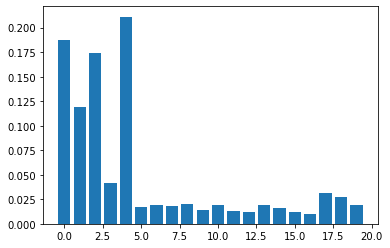

In [143]:
print(rf1.best_estimator_.feature_importances_)
# plot
pyplot.bar(range(len(rf1.best_estimator_.feature_importances_)), rf1.best_estimator_.feature_importances_)
pyplot.show()

In [145]:
# Random Forest feature importance
fi_df = pd.DataFrame({'fi': rf1.best_estimator_.feature_importances_},index=training_features.columns).sort_values(by='fi', ascending=False)
fi_df

,fi
Credit_History,0.211115
ApplicantIncome,0.187446
LoanAmount,0.173979
CoapplicantIncome,0.119291
Loan_Amount_Term,0.041363
Property_Area_Rural,0.031285
Property_Area_Semiurban,0.027590
Married_Yes,0.020140
Education_Graduate,0.019660
Gender_Male,0.019072


In [91]:
import pandas as pd

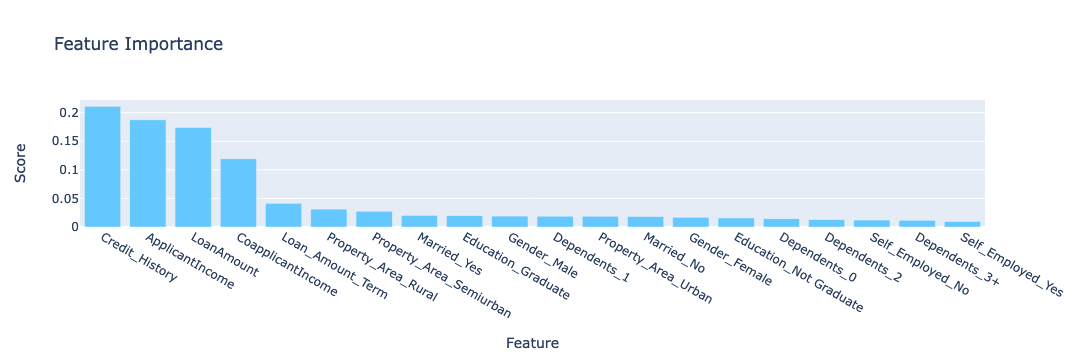

In [146]:
# display results with plotly
trace0 = go.Bar(x= fi_df.index,
                y= fi_df['fi'].values,
                marker=dict(color='rgb(100,200,300)'))

# now the layout
layout=go.Layout(title='Feature Importance',
                   xaxis= dict(title='Feature'),
                   yaxis=dict(title='Score'))
# bind using go.Figure
fig = go.Figure(data=[trace0], layout=layout)
fig

In [147]:
# what are the key variables like?
X_test[['Credit_History', 'ln_total_income', 'ln_monthly_return', 'ln_LoanAmount']].sample(3).T

/tmp/ipykernel_4024/4154293101.py:2: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Pickle the model and its preprocessing steps

In [43]:
# save the dataframes for visualization
approved.to_csv('../model_components/approved_loans.csv', index=False)
denied.to_csv('../model_components/denied_loans.csv', index=False)

In [44]:
# pickle your random forest model
filename = open('../model_components/loan_approval_rf_model.pkl', 'wb')
pickle.dump(rf, filename)
filename.close()

In [45]:
# encoder1
filename = open('../model_components/loan_approval_onehot_encoder.pkl', 'wb')
pickle.dump(encoder1, filename)
filename.close()

In [46]:
# ss_scaler1: monthly_return
filename = open('../model_components/loan_approval_ss_scaler1.pkl', 'wb')
pickle.dump(ss_scaler1, filename)
filename.close()

In [47]:
# ss_scaler2: ln_total_income
filename = open('../model_components/loan_approval_total_income.pkl', 'wb')
pickle.dump(ss_scaler2, filename)
filename.close()

In [48]:
# ss_scaler3: loan_amount
filename = open('../model_components/loan_approval_loan_amount.pkl', 'wb')
pickle.dump(ss_scaler3, filename)
filename.close()